COMP 215 - LAB 5
----------------
#### Name(s):
#### Date:

By the end of this lab you should be able to:
  * apply both a direct (ie. brute force) and heuristic algorithm to a problem
  * use the networkx module to visualize graphs
  * measure algorithm scaling


During this lab, you will be introduced to the following:
  * seeding the random module



## The Traveling Salesperson Problem

This lab is based on the famous Traveling Salesperson Problem (TSP) outlined in Section 3.3.2 of 'On Complexity'.  Imagine you needed to travel to ten different cities.  What is the sortest possible route you could take to visit every city?  For our version of the problem, you start from a specific city and must end on the same city.

In this lab, you will implement a direct (ie. brute force) and a heuristic solution to the problem.

In [14]:
# start with some imports
import random, math, time, itertools
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

## Set up the map

For this implementation of the problem we will randomly place N cities on a 100 by 100 grid.  Cities will be labelled using a single character; 'A', 'B', 'C', etc.  City locations will be denoted by a 2-tuple, `(x,y)`, giving their position on the grid. In order to create reproducable maps, we will use [random.seed()](https://docs.python.org/3/library/random.html#random.seed) to initialize the random module.  

In [2]:
def setup_map(N, seed=1):
  ''' Returns a map of N cities with random locations on a 100 by 100 grid '''
  random.seed(seed)
  city_locations = [(random.randint(0, 100), random.randint(0, 100)) for i in range(N)]
  city_names = [chr(65 + i) for i in range(N)]
  city_map = dict(zip(city_names, city_locations))
  return city_map

def graph_map(city_map):
  ''' graph the map of cities using networkx'''
  G = nx.Graph()
  G.add_nodes_from(city_map)
  nx.draw(G, city_map, with_labels=True)

def distance(city1, city2, city_map):
  ''' Returns the distance between two cities on a map'''
  x1, y1 = city_map[city1]
  x2, y2 = city_map[city2]
  return round(math.sqrt((x2 - x1)**2 + (y2 - y1)**2),1)

def calculate_distances(city_map):
  ''' Returns a dictionary with the distances between all pairs of cities in a map '''
  distances = {}
  for city1 in city_map:
      for city2 in city_map:
          if city1 != city2:
              # this will have duplicate distances (A,B) and (B,A)
              # these duplicates make the algorithm implememntation simpler
              distances[(city1, city2)] = distance(city1, city2, city_map)
  return distances


City Map: {'A': (17, 72), 'B': (97, 8), 'C': (32, 15), 'D': (63, 97), 'E': (57, 60), 'F': (83, 48), 'G': (100, 26), 'H': (12, 62), 'I': (3, 49), 'J': (55, 77)}
Distances between cities: {('A', 'B'): 102.4, ('A', 'C'): 58.9, ('A', 'D'): 52.4, ('A', 'E'): 41.8, ('A', 'F'): 70.2, ('A', 'G'): 94.9, ('A', 'H'): 11.2, ('A', 'I'): 26.9, ('A', 'J'): 38.3, ('B', 'A'): 102.4, ('B', 'C'): 65.4, ('B', 'D'): 95.3, ('B', 'E'): 65.6, ('B', 'F'): 42.4, ('B', 'G'): 18.2, ('B', 'H'): 100.7, ('B', 'I'): 102.6, ('B', 'J'): 80.8, ('C', 'A'): 58.9, ('C', 'B'): 65.4, ('C', 'D'): 87.7, ('C', 'E'): 51.5, ('C', 'F'): 60.7, ('C', 'G'): 68.9, ('C', 'H'): 51.1, ('C', 'I'): 44.7, ('C', 'J'): 66.1, ('D', 'A'): 52.4, ('D', 'B'): 95.3, ('D', 'C'): 87.7, ('D', 'E'): 37.5, ('D', 'F'): 52.9, ('D', 'G'): 80.1, ('D', 'H'): 61.9, ('D', 'I'): 76.8, ('D', 'J'): 21.5, ('E', 'A'): 41.8, ('E', 'B'): 65.6, ('E', 'C'): 51.5, ('E', 'D'): 37.5, ('E', 'F'): 28.6, ('E', 'G'): 54.8, ('E', 'H'): 45.0, ('E', 'I'): 55.1, ('E', 'J'): 17.1,

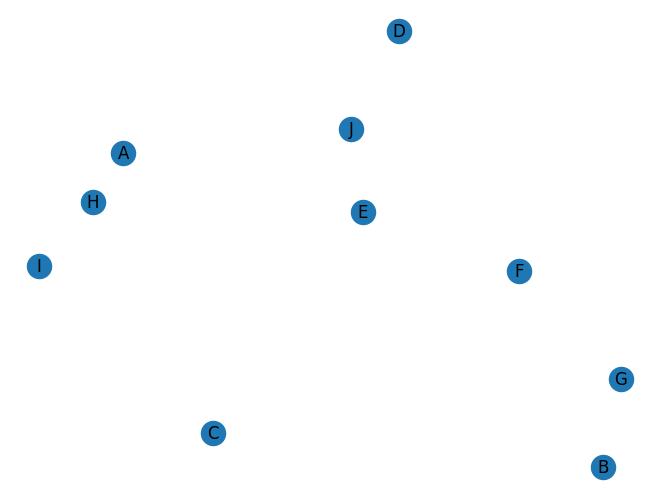

In [3]:
# test our setup functions
city_map = setup_map(10)
print(f'City Map: {city_map}')
distances = calculate_distances(city_map)
print(f'Distances between cities: {distances}')
graph_map(city_map)

### Exercise 1: The Brute Force Solution

Implement a brute force solution to the traveling salesman problem using the city map and distance dictionary given above.  The algorithm for the brute force solution looks something like this:
 1. Loop over every possible route that starts and ends on city A.  For a three city example, this would be ABCA, ACBA.  
 2. Calculate the total distance of each possible route.  
 3. Find the route with the minimum total distance.

Before you start coding, think about what functions and/or class you might want to simplify your implementation of the algorithm.  Write a small test for your algorithm.

In [ ]:
# Ex. 1 your solution here

In [12]:
# this solution is based on: https://medium.com/@davidlfliang/intro-python-algorithms-traveling-salesman-problem-ffa61f0bd47b

def total_distance(route, distances):
    ''' calculate the total distance of a route
        paramters:  route (list) sequence of cities
                    distances (dict) dictionary of distances between cities
        returns: total distance (float)
    '''
    total_distance = 0
    n = len(route)
    for i in range(n):
        current_city = route[i]
        next_city = route[(i + 1) % n]  # Wrap around to the start of the route
        total_distance += distances[(current_city, next_city)]
    return round(total_distance,1)

def brute_force_algorithm(city_map, distances):
  ''' Brute force solution to the traveling salesman problem
      parameters: city_map (dict) dictionary of cities and their locations
                  distances (dict) dictionary of distances between cities
      returns: optimal_route (tuple), min_distance (float)'''

  # create the list of cities from the city map
  cities = city_map.keys()

  # Generate all permutations of the cities
  all_permutations = itertools.permutations(cities)
  valid_permutations = [perm for perm in all_permutations if perm[0] == 'A']

  # Initialize variables to track the minimum distance and corresponding route
  min_dist = float('inf')
  optimal_route = None

  # Iterate over valid permutations and calculate distance
  for perm in valid_permutations:
    dist = total_distance(perm, distances)
    if dist < min_dist:
        min_dist = dist
        optimal_route = perm + (perm[0],)  # Add the starting city to the end of the route
  return optimal_route, min_dist

# Apply the brute force algorithm
bf_route, bf_distance = brute_force_algorithm(city_map, distances)

# Print the optimal route and its distance
print(f"Brute Force Optimal Route: {bf_route}")
print(f"Total Distance: {bf_distance}")


Brute Force Optimal Route: ('A', 'B', 'C', 'A')
Total Distance: 226.7


### Exercise 2: Nearest Neighbour

Implement a nearest neighbour solution to the traveling salesman problem using the city map and distance dictionary given above.  The algorithm for the nearest neighbour solution looks something like this:
 1. Start from the starting city.  
 2. Go to the nearest city that has not been visited.  
 3. Repeat steps 1 and 2 until all cities have been visited.

Before you start coding, think about what functions and/or class you might want to simplify your implementation of the algorithm.  Write a small test for your algorithm.

In [ ]:
# Ex.2 your code here

In [6]:
# this solution is based on: https://medium.com/@davidlfliang/intro-python-algorithms-traveling-salesman-problem-ffa61f0bd47b
# note that the online solution requires the distances dictionary to have distances in both directions, ie keys (A,B) and (B,A)

# Nearest Neighbor Algorithm function
def nearest_neighbor_algorithm(city_map, distances):
    ''' Nearest neighbor solution to the traveling salesman problem
        parameters: city_map (dict) dictionary of cities and their locations
                    distances (dict) dictionary of distances between cities
        returns: optimal_route (tuple), min_distance (float)'''

    # initialize
    cities = list(city_map.keys())
    n = len(cities)
    visited = [False] * n
    path = []
    total_distance = 0.0

    # start from the first city
    current_city = cities[0]
    path.append(current_city)
    visited[cities.index(current_city)] = True

    # repeat until all cities are visited
    while len(path) < n:
        nearest_city = None
        nearest_distance = float('inf')

        # Find the nearest unvisited city
        for city in cities:
            if not visited[cities.index(city)] and (current_city, city) in distances:
                distance = distances[(current_city, city)]
                if distance < nearest_distance:
                    nearest_distance = distance
                    nearest_city = city

        # Move to the nearest city
        total_distance += nearest_distance
        current_city = nearest_city
        path.append(current_city)
        visited[cities.index(current_city)] = True

    # Return to the starting city
    total_distance += distances.get((current_city, path[0]), distances.get((path[0], current_city)))
    path.append(path[0])

    return tuple(path), round(total_distance,1)

# Apply nearest neighbor algorithm
nn_route, nn_distance = nearest_neighbor_algorithm(city_map, distances)

# Print the result
print("Nearest Neighbor Optimal Route:", nn_route)
print("Total Distance:", nn_distance)

Nearest Neighbor Optimal Route: ('A', 'H', 'I', 'C', 'E', 'J', 'D', 'F', 'G', 'B', 'A')
Total Distance: 363.1


### Exercise 3: Graph the Routes

Use the networkx module to create directed graphs of the routes (brute force and nearest neighbour).  Include the distances between the cities on the edges.  Run several different map setups with a different sizes (ie. number of cities).  Do the brute force (ie. direct) and nearest neighbour (ie. heuristic) algorithms always give the same solution?  Do you notice anything about the brute force solutions that suggests an alternative heuristic algorithm?


In [ ]:
# Ex.3 your code here

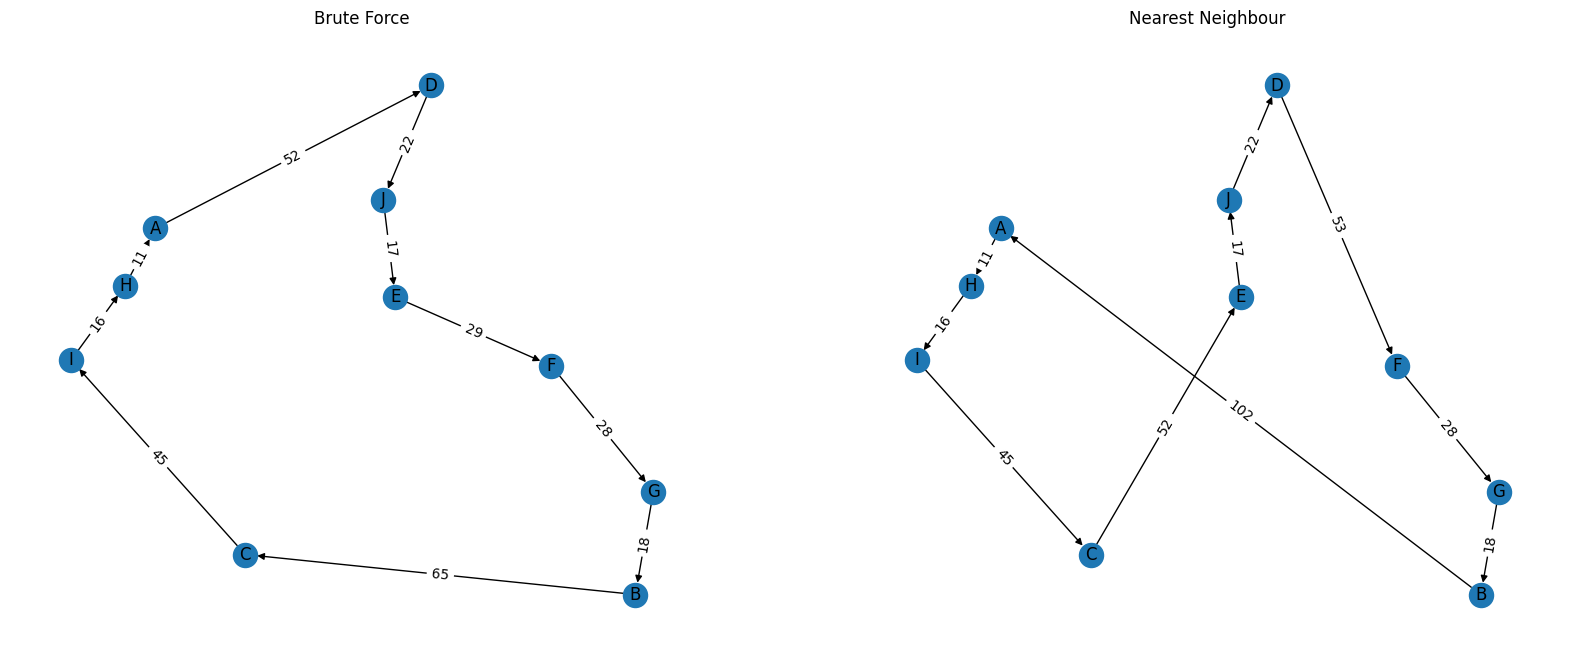

In [9]:
def graph_route(route, title, subplot):
  ''' graph the route of cities using networkx
      parameters: route (tuple) of the route
                  subplot (ax object) to graph the route on'''
  G = nx.DiGraph()
  G.add_nodes_from(city_map)
  edges = []
  for i in range(len(route)-1):
    edges.append((route[i], route[i+1]))
  G.add_edges_from(edges)
  nx.draw(G, city_map, ax=subplot, with_labels=True)
  subplot.set_title(title)

  # draw edge labels
  for edge in edges:
    nx.draw_networkx_edge_labels(G, city_map, ax=subplot, edge_labels={edge: round(distances[edge])})

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# graph the routes on the subplots
graph_route(bf_route, 'Brute Force', axes[0])
graph_route(nn_route, 'Nearest Neighbour', axes[1])


### Exercise 4: Algorithm Scaling

Use the `time` module to measure the running time of the two algorithms.  Note that the `time.time()` function returns the current time, so calling it before and after the algorithm has run can give you the time it takes for the algorithm to execute.  Taking the average over several trials will make the measurement more precise.  Demonstrate the scaling nature of the algorithms by plotting their execution time as a function of N, up to about N = 10.  

In [ ]:
# Ex 4: your code here

In [ ]:

def timeit(algorithm, n_trials=10):
  ''' time an algorithm by running it n_trials times and returning the average time
      parameters: algorithm (function) to be timed
                  n_trials (int) the number of times to run the algorithm
      returns: (float) average exectution time of the algorithm
  '''
  total=0
  for i in range(n_trials):
    start= time.time()
    algorithm(city_map, distances)
    end= time.time()
    total += end-start
  return total/n_trials

print(f'brute force: {timeit(brute_force_algorithm)} seconds')
print(f'nearest neighbour {timeit(nearest_neighbor_algorithm)} seconds')



In [ ]:
# determine the time for N cities for each algorithm
bf_times = {}
nn_times = {}
for i in range(4,11):
  print(f'N = {i}')
  city_map = setup_map(i)
  distances = calculate_distances(city_map)
  bf_times[i] = timeit(brute_force_algorithm)
  nn_times[i] = timeit(nearest_neighbor_algorithm)

print(bf_times)
print(nn_times)



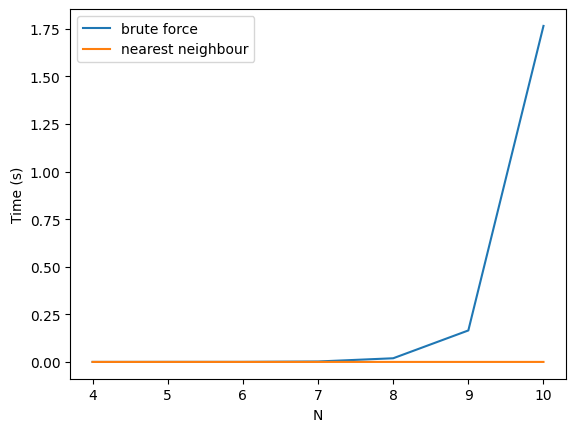

In [18]:
# plot the time for each algorithm as a function of N
plt.plot(list(bf_times.keys()), list(bf_times.values()), label='brute force')
plt.plot(list(nn_times.keys()), list(nn_times.values()), label='nearest neighbour')
plt.xlabel('N')
plt.ylabel('Time (s)')
plt.legend()
plt.show()